In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib as plt
import matplotlib.pyplot as pplt
plt.style.use('classic')
%matplotlib inline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
sns.set()

In [2]:
# Read train data
train_data = pd.read_csv('data/train.csv')

# Read test data
test_data = pd.read_csv('data/test.csv')

# Sepeate response variable from predictor variables.
X = train_data
y = train_data["Survived"]

In [3]:
'Dimensions of train data:' + str(X.shape)

'Dimensions of train data:(891, 12)'

In [4]:
X.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [5]:
# How many missing fields on each variable at train_data?
X.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
# How many missing fields on each variable at test_data?
test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [7]:
# Combine all data. The data will be submitted in the kaggle competition.
combined_data = [test_data, X]
# Transform data from characters to numeric.
embarked = {"S":0, "C":1, "Q":2}
sex = {"male":0, "female":1}
cabin = {"A":1, "B":2, "C":3, "D":4, "E":5, "F":6, "G":7, "T":8}

# Change both train and test data.
for df in combined_data:
    df['Sex'] = df['Sex'].map(sex)
    # Fill empty with Southampton. The ship sailed from Southampton.
    df['Embarked'] = df['Embarked'].fillna('S')
    df['Embarked'] = df['Embarked'].map(embarked)
    # Fill NA
    df['Cabin'].fillna(0, inplace = True)
    # We are interested in the cabin group not the numbers.
    df['Cabin'] = df['Cabin'].str[:1]
    df['Cabin'] = df['Cabin'].map(cabin)
    # Fill empty ages with the mean value of each gender.
    df['Age'].fillna(df.groupby("Sex")["Age"].transform("mean"), inplace = True)
    # Fill empty with the mean value of each pclass.
    df["Fare"].fillna(df.groupby("Pclass")["Fare"].transform("mean"), inplace = True)
    # Since we have many ages, we group them.
    df.loc[ df['Age'] <= 17, 'Age'] = 0,
    df.loc[(df['Age'] > 17) & (df['Age'] <= 25), 'Age'] = 1,
    df.loc[(df['Age'] > 25) & (df['Age'] <= 45), 'Age'] = 2,
    df.loc[(df['Age'] > 45) & (df['Age'] <= 60), 'Age'] = 3,
    df.loc[ df['Age'] > 60, 'Age'] = 4
    # Group the fare.
    df.loc[ df['Fare'] <= 40, 'Fare'] = 0,
    df.loc[(df['Fare'] > 40) & (df['Fare'] <= 60), 'Fare'] = 1,
    df.loc[(df['Fare'] > 60) & (df['Fare'] <= 150), 'Fare'] = 2,
    df.loc[ df['Fare'] > 150, 'Fare'] = 3    

In [8]:
# Check if data are ok.
X.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1AEFE370>,
      dtype=object)

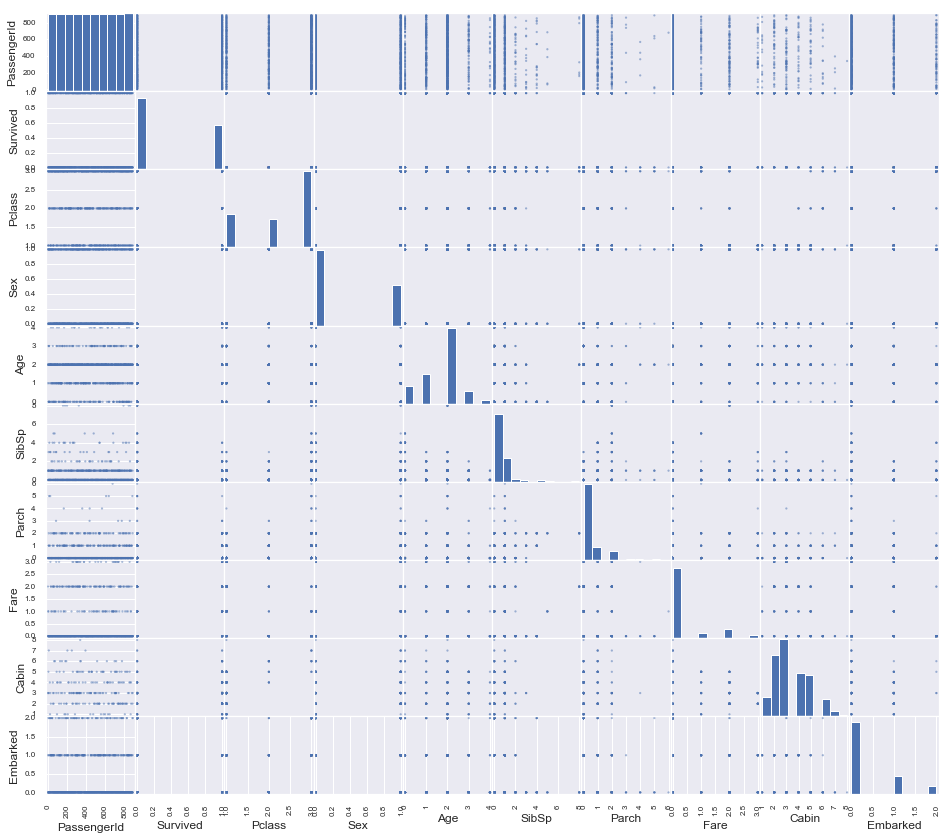

In [9]:
# Scatter plot.
pd.plotting.scatter_matrix(X, figsize = (16,14))

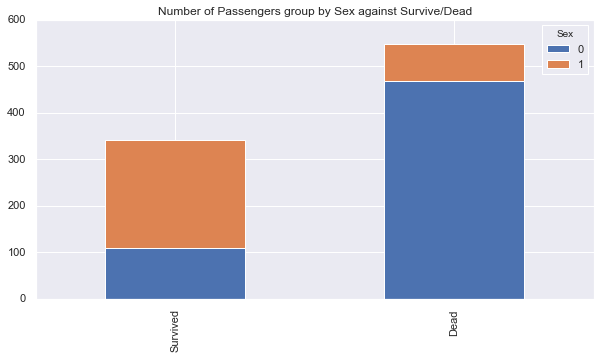

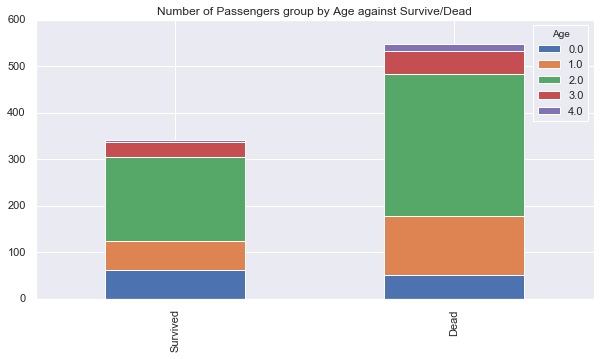

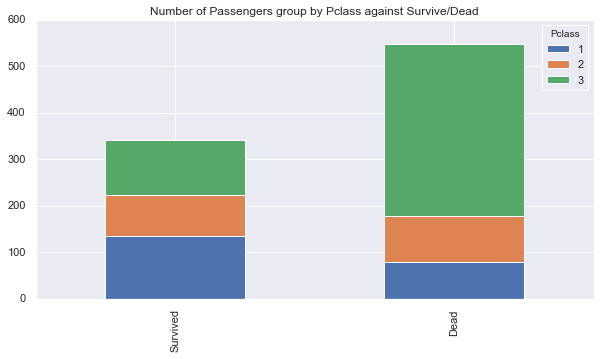

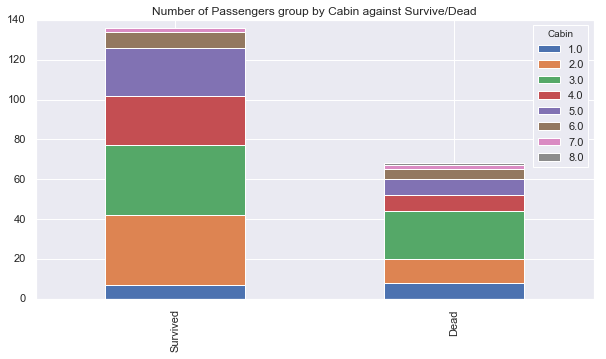

In [10]:
# Methods - Classifiers
def chart(variables):
    for variable in variables:
        dead = (X[(X['Survived']==0)][variable].groupby([X[variable]]).count())
        survived = (X[(X['Survived']==1)][variable].groupby([X[variable]]).count())
        surv_dead = pd.DataFrame([survived,dead])
        surv_dead.index = ['Survived','Dead']
        surv_dead.plot(kind='bar',stacked=True, figsize=(10,5), title = "Number of Passengers group by " + str(variable) + " against Survive/Dead")
        
chart(["Sex", "Age", "Pclass", "Cabin"])    

In [11]:
alive = (X[(X['Survived']==1)]["Embarked"].groupby([X["Embarked"]]).count())
dead  = (X[(X['Survived']==0)]["Embarked"].groupby([X["Embarked"]]).count())

alive/(alive + dead)

Embarked
0    0.339009
1    0.553571
2    0.389610
Name: Embarked, dtype: float64

In [12]:
k_fold = KFold(n_splits = 10, shuffle = True, random_state = 0)

features_drop = ['Ticket', 'Parch', 'Name', 'Cabin']

train_x       = X.drop(features_drop, axis = 1)

test_model    = test_data.drop(features_drop, axis = 1)

train_model_t = train_x.drop("Survived", axis = 1)

train_model   = train_model_t.drop("PassengerId", axis = 1)

target        = train_x['Survived']

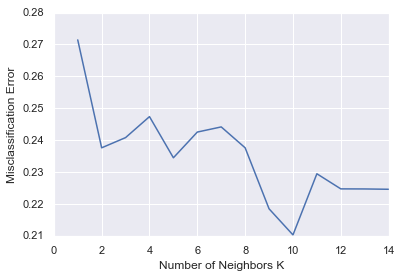

In [13]:
X_train, X_test, y_train, y_test = train_test_split(train_model, y, test_size=0.30)

neighbors = list(range(1,15))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]

# plot misclassification error vs k
pplt.plot(neighbors, MSE)
pplt.xlabel('Number of Neighbors K')
pplt.ylabel('Misclassification Error')
pplt.show()

In [14]:
def classifiers(classifier, scor = "accuracy"):
    score = cross_val_score(classifier, train_model, target, cv=k_fold, n_jobs=1, scoring=scor)
    print(1-score)
    print(round(100-np.mean(score)*100, 2))
    return(score)
    
def metrics_confusion(model):    
    model.fit(train_model, target)
    predictions = model.predict(train_model)
    print("Model: " + str(type(model)))
    print(metrics.confusion_matrix(target, predictions))
    print("\n")

def classic_report(model):
    model.fit(X_train, y_train)
    predicted = model.predict(X_test)
    report = classification_report(y_test, predicted)
    print(report + "\n\n")

In [15]:
rf = classifiers(RandomForestClassifier(n_estimators=20))
kn = classifiers(KNeighborsClassifier(n_neighbors = 7))
lg = classifiers(LogisticRegression())
sv = classifiers(SVC())

classic_report(RandomForestClassifier(n_estimators=20))
classic_report(KNeighborsClassifier(n_neighbors = 7))
classic_report(LogisticRegression())
classic_report(SVC())

metrics_confusion(RandomForestClassifier(n_estimators=20))
metrics_confusion(KNeighborsClassifier(n_neighbors = 7))
metrics_confusion(LogisticRegression())
metrics_confusion(SVC())

clf = SVC(kernel="linear", C=1).fit(X_train, y_train)
clf.score(X_test,y_test)

[0.2        0.20224719 0.25842697 0.19101124 0.19101124 0.20224719
 0.21348315 0.24719101 0.29213483 0.19101124]
21.89
[0.22222222 0.16853933 0.21348315 0.23595506 0.16853933 0.21348315
 0.20224719 0.26966292 0.25842697 0.19101124]
21.44
[0.18888889 0.21348315 0.20224719 0.2247191  0.23595506 0.19101124
 0.2247191  0.17977528 0.20224719 0.16853933]
20.32


c:\users\manos\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\manos\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\manos\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\manos\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\manos\appdata\local\programs\python\pyt

[0.2        0.20224719 0.19101124 0.20224719 0.15730337 0.19101124
 0.21348315 0.17977528 0.17977528 0.19101124]
19.08
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       157
           1       0.78      0.68      0.72       111

   micro avg       0.79      0.79      0.79       268
   macro avg       0.79      0.77      0.78       268
weighted avg       0.79      0.79      0.78       268



              precision    recall  f1-score   support

           0       0.77      0.85      0.81       157
           1       0.76      0.64      0.69       111

   micro avg       0.76      0.76      0.76       268
   macro avg       0.76      0.75      0.75       268
weighted avg       0.76      0.76      0.76       268



              precision    recall  f1-score   support

           0       0.80      0.87      0.84       157
           1       0.79      0.69      0.74       111

   micro avg       0.80      0.80      0.80       268
   ma

c:\users\manos\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\manos\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\manos\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\manos\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\l

0.7985074626865671

In [16]:
def train_cross_plot(est, title, ylim):
    pplt.figure()
    pplt.title(title)
    
    pplt.ylim(*ylim)
    pplt.xlabel("Training examples")
    pplt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        est, X_train, y_train, cv = k_fold, n_jobs = 4, train_sizes = np.linspace(.1, 1.0, 5))
    
    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std  = np.std(train_scores, axis = 1)
    test_scores_mean  = np.mean(test_scores, axis = 1)
    test_scores_std   = np.std(test_scores, axis = 1)
    
    pplt.grid()

    pplt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    
    pplt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    pplt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    
    pplt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    pplt.legend(loc="best")
    
    return pplt



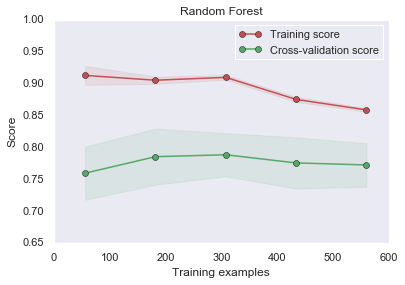

In [17]:
train_cross_plot(RandomForestClassifier(n_estimators = 20), "Random Forest", (0.65, 1))

pplt.show()

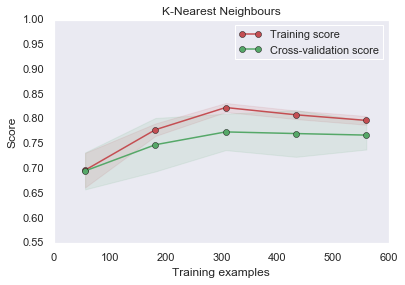

In [18]:
train_cross_plot(KNeighborsClassifier(n_neighbors = 19), "K-Nearest Neighbours", (0.55, 1))

pplt.show()

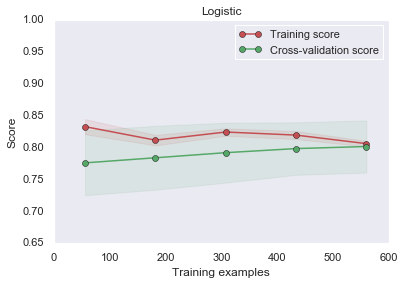

In [19]:
train_cross_plot(LogisticRegression(), "Logistic", (0.65, 1))

pplt.show()

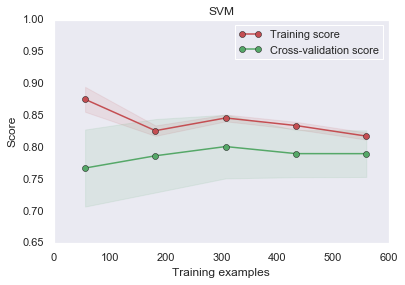

In [20]:
train_cross_plot(SVC(), "SVM", (0.65, 1))

pplt.show()

In [21]:
# Choose best
classfier = SVC() 
classfier = RandomForestClassifier(n_estimators = 20)

classfier.fit(train_model, target)

test_data_ = test_model.drop("PassengerId", axis = 1).copy()
prediction = classfier.predict(test_data_)

# Create a csv file to submit to Kaggle.
submission = pd.DataFrame({
        "PassengerId": test_model["PassengerId"],
        "Survived": prediction
})

submission.to_csv('submissionKaggleTitanic.csv', index = False)